<a href="https://colab.research.google.com/github/lucamatteucci10/BA820-team-10/blob/main/Project%20820/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Sentiment Analysis**

**Team 10**

* Luca Matteucci
* Neeharika Kamireddy
* Haaniya Umair
* Sneha Jayapradeep
* Chirayu (Mitthi) Jain

## Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import re
import nltk
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
import sklearn
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score





## Mounting the Drive and Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_project_820/Tweet_data.csv', encoding='ISO-8859-1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Let's dive into the dataset a bit more. We have 1.6M rows and 6 attributes.

## Exploring the Dataset

In [ ]:
df.shape

(1600000, 6)

We can also dive in to check for any null values and learn what kind of datatypes are in each column.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


It looks like we have two numerical columns and the rest are objects/text. It seems that there are no null values either, but let's just double check to make sure.

## Data Cleaning

In [ ]:
df.isna().sum()

polarity    0
id          0
date        0
query       0
user        0
text        0
dtype: int64

There are no null values so let's look at the distribution for the numerical columns.

In [ ]:
df.describe()

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [ ]:
df['polarity'].unique()

array([0, 4])

The polarity looks a bit off and by digging in deeper we learn its because the assigned values are either 0 or 4, to make it easier for us to understand the dataset, we will replace it with 0 and 1.

In [ ]:
df['polarity'] = df['polarity'].replace({4: 1})

In [ ]:
df.describe()

,polarity,id
count,1600000.0,1.600000e+06
mean,0.5,1.998818e+09
std,0.5,1.935761e+08
min,0.0,1.467810e+09
25%,0.0,1.956916e+09
50%,0.5,2.002102e+09
75%,1.0,2.177059e+09
max,1.0,2.329206e+09


Now we want to check for any duplicates in any of the rows to make sure the 1.6M rows are unique tweets instead of duplicates.

In [ ]:
df.duplicated().sum()

0

Looks like we have no duplicate tweets, which is great. Now we can check for how many unique users we have in the dataset.

In [ ]:
df['user'].nunique()

659775

## Exploratory Data Analysis

**Top 10 Users by Tweet Count**

There are over 600,000 users, so while we can't plot how many tweets each user has, we can definitely dive into the top 10 users in the dataset and see weather they had mostly positive or negative tweets.

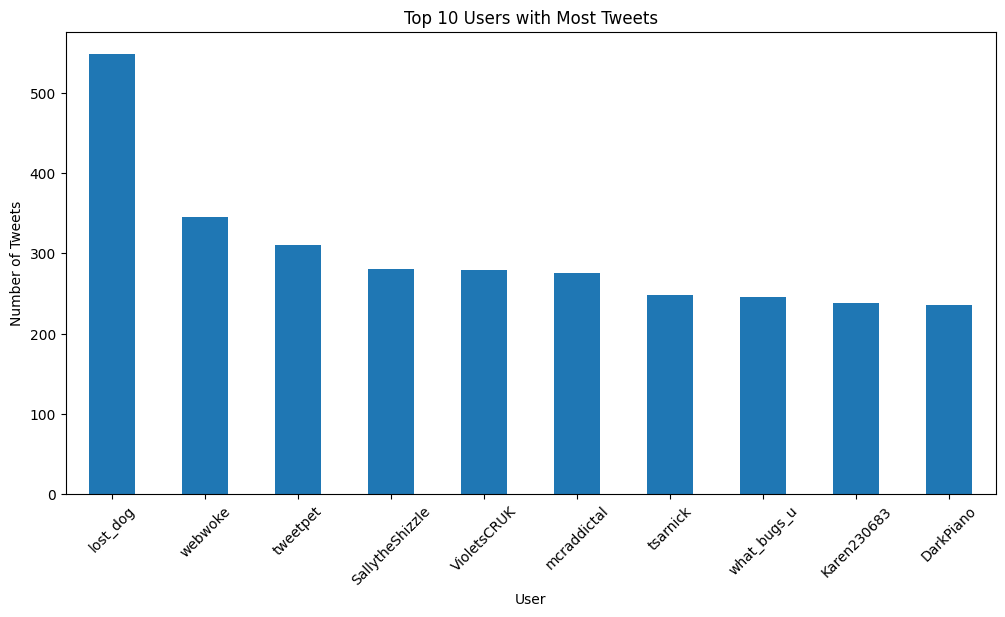

In [ ]:
top_users = df['user'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
top_users.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Number of Tweets')
plt.title('Top 10 Users with Most Tweets')
plt.xticks(rotation=45)
plt.show()

**Sentiment Breakdown: Top 10 Users**

<Figure size 1200x600 with 0 Axes>

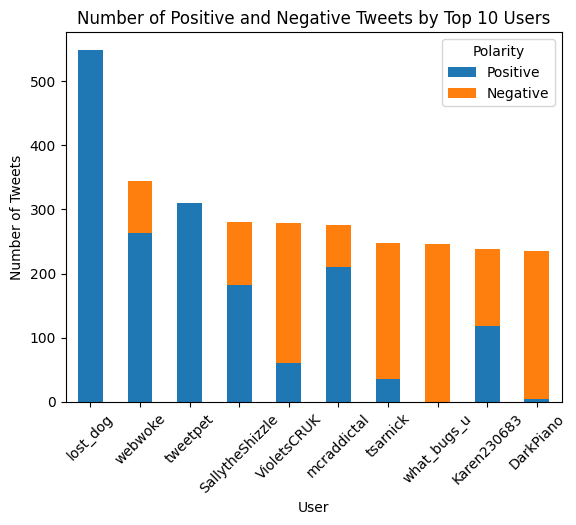

In [ ]:
top_users = df['user'].value_counts().nlargest(10).index
top_users_df = df[df['user'].isin(top_users)]
counts = top_users_df.groupby(['user', 'polarity']).size().unstack(fill_value=0)
counts['total_tweets'] = counts.sum(axis=1)
counts = counts.sort_values(by='total_tweets', ascending=False)
plt.figure(figsize=(12, 6))
counts.drop('total_tweets', axis=1).plot(kind='bar', stacked=True)
plt.xlabel('User')
plt.ylabel('Number of Tweets')
plt.title('Number of Positive and Negative Tweets by Top 10 Users')
plt.xticks(rotation=45)
plt.legend(title='Polarity', labels=['Positive', 'Negative'])
plt.show()

We can also dive in to see weather the dataset has mostly positive, or mostly negative tweets - to guage the overall sentiment analysis at a first glance.

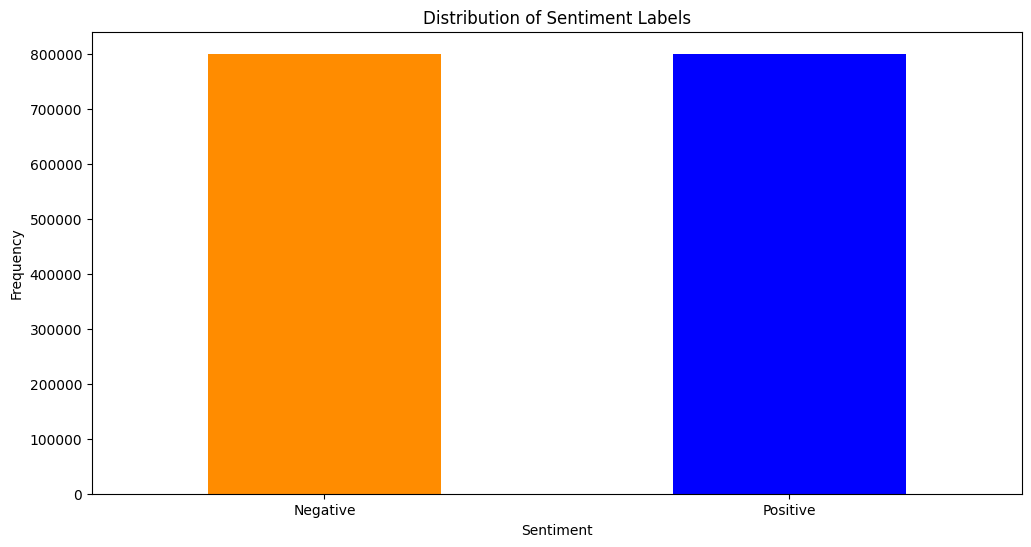

Proportion of Positive Tweets: 50.00%
Proportion of Negative Tweets: 50.00%


In [ ]:
sentiment_counts = df['polarity'].value_counts()

plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', color=['darkorange', 'b'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.xticks(rotation=0, ticks=[0, 1],labels=['Negative', 'Positive'])
plt.show()

positive_tweets = sentiment_counts[1]
negative_tweets = sentiment_counts[0]
positive_percentage = (positive_tweets / sentiment_counts.sum()) * 100
negative_percentage = (negative_tweets / sentiment_counts.sum()) * 100
print(f"Proportion of Positive Tweets: {positive_percentage:.2f}%")
print(f"Proportion of Negative Tweets: {negative_percentage:.2f}%")

Looks like theres exactly the same number of positive and negative tweets, and none that were classified as neutral. This does not seem like something we would authentically find in a dataset, so I think maybe the datashit was conditioned to classify all its tweets equally into one or the other. This probably means that a lot of 'neutral' tweets were incorrectly classified.

**Taking a random sample**

In [ ]:
#Sample to 1.75% of the dataset for faster processing
df_new = df.sample(frac=0.1, random_state=42)
# df_new = df.sample(frac=0.0175, random_state=42)
df_new

,polarity,id,date,query,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
...,...,...,...,...,...,...
1574177,1,2189199207,Mon Jun 15 23:28:21 PDT 2009,NO_QUERY,mainbasket,@willjonz thank you Will
49646,0,1678213724,Sat May 02 05:56:37 PDT 2009,NO_QUERY,MagicElla,@HeartlessHippie AAAAAAAAH what's wrong?!
1317229,1,2014242841,Wed Jun 03 00:53:53 PDT 2009,NO_QUERY,kewlrats,@samhouston Will see you there tomorrow at the...
520455,0,2192116541,Tue Jun 16 06:32:06 PDT 2009,NO_QUERY,iXombie,Forgot that Xbox Live would be down today.


## Text Cleaning

In [ ]:
# convert every character to lower case.
df_new['text'] = df_new['text'].str.lower()

In [ ]:
# remove URL links but keeps the rows
df_new['text'] = df_new['text'].str.replace(r'http\S+', '', regex=True)

In [ ]:
def clean_text(text):
    # Define a pattern to match unwanted characters, excluding alphanumeric characters, spaces, and specific old school emoticons
    unwanted_chars_pattern = r'(?<![:;])-|[^a-zA-Z0-9\s:;]+'

    # Split the text into words, symbols, and potential emoticons, and rebuild the text keeping only the desired characters and patterns
    split_text = re.findall(r'\w+|[:;]-?[)DpPoO(/\\|*]|[\s]', text, re.UNICODE)

    cleaned_text = ''.join([word if re.match(unwanted_chars_pattern, word) is None or word.isspace() or word in [':)', ';)'] else ' ' for word in split_text])

    return cleaned_text.strip()

In [ ]:
# Cleaning from unwanted characters
df_new['text'] = df_new['text'].apply(clean_text)

## Analysis and Modeling

### Tokenization

We used tokenization to break down the text into individual words or tokens, making it easier to analyze and process the text.

In [ ]:
# Tokenize converting all tweets to lower case, eliminating tweet username and reducing lenght of word like niiiiiiiceeeeee to nice
tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

tokenized = [tknzr.tokenize(t) for t in df_new['text']]


In [ ]:
# Remove stop words from each tweet
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
filtered_tokens = [[word for word in tweet if word not in stop_words] for tweet in tokenized]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Handling negation words like not, no etc.
def handle_negations(tokens):
    negation_words = {'not', "n't", 'no', 'never', 'none'}
    for i, word in enumerate(tokens):
        if word in negation_words and i < len(tokens) - 1:
            tokens[i+1] = 'not_' + tokens[i+1]
    return tokens

handled_negations_tokens = [handle_negations(tweet) for tweet in filtered_tokens]

Here, we have handled negations as these words are helpful for analyzing the sentences. Negation words provide accurate interpretation of sentences.

### Stemming and lemmatization

 Stemming and lemmatization were employed to reduce words to their root form, this is to ensure consistency and reduce dimensionality in our analysis.



In [ ]:
# Lemmatization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [[lemmatizer.lemmatize(word) for word in tweet] for tweet in handled_negations_tokens]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Stemming
stemmer = PorterStemmer()

stemmed_tokens = [[stemmer.stem(word) for word in tweet] for tweet in lemmatized_tokens]

In [ ]:
# Join the stemmed tokens back into strings
stemlem_texts = [" ".join(tokens) for tokens in lemmatized_tokens]

### Bag of Words

Even though BoW does not account for the word order or context, we want to use it as baseline model for sentiment analysis. We want to determine the frequency of specific words in the dataset, hoping that we can identify common themes and keywords to gauge sentiments.

In [ ]:
vectorizer = CountVectorizer()
BoW_matrix = vectorizer.fit_transform(stemlem_texts)
BoW_df = pd.DataFrame(BoW_matrix.toarray(), columns=vectorizer.get_feature_names_out())
BoW_df

,00,000,000th,001,0013,002,004,007,008,00am,...,zuzubrandy,zwagger,zwalkk,zxch,zxcv,zxed,zycam,zyrtec,zz,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
word_freq = BoW_df.sum(axis = 0).sort_values(ascending = False)
word_freq

day            1822
good           1601
get            1518
like           1392
go             1367
               ... 
indulge           1
induced           1
indo              1
indifferent       1
located           1
Length: 34999, dtype: int64

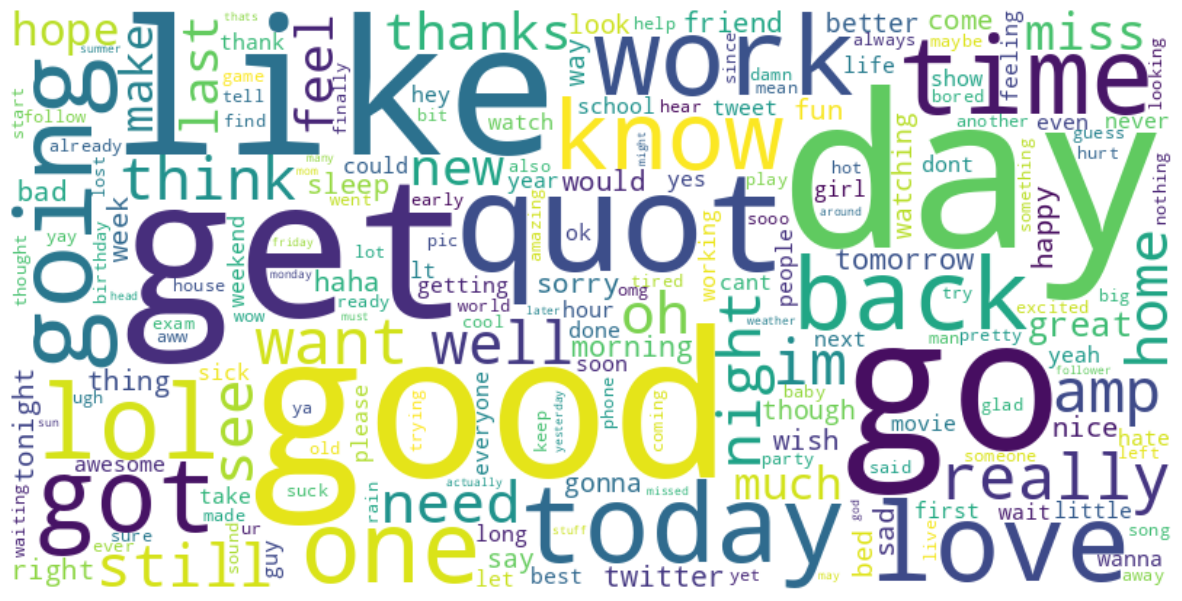

In [ ]:
#Wordcloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In the figure above we can see our preliminary ‘WordCloud’ using BoW, it doesn’t seem the most useful for sentiment analysis as we cannot gather any insights related to sentiments of the tweets. We do see words such as ‘love’, ‘like’, ‘good’ - but again, since context was not considered in BoW it is hard to draw any conclusions about the sentiment.

### TF - IDF

TF-IDF was used to improve upon BoW by taking into account the importance of words not just the individual words but also their context in the entire dataset. This helped us identify more 'discriminative' features for sentiment classification.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(stemlem_texts)
tfidf_array = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,00,000,000th,001,0013,002,004,007,008,00am,...,zuzubrandy,zwagger,zwalkk,zxch,zxcv,zxed,zycam,zyrtec,zz,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidf_sparse = csr_matrix(tfidf_df.values)
cos_sim_sparse = cosine_similarity(tfidf_sparse, tfidf_sparse)
cos_sim_df = pd.DataFrame(cos_sim_sparse)
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,...,27990,27991,27992,27993,27994,27995,27996,27997,27998,27999
0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.091719,0.0,0.0,0.0,0.000000,0.08767,0.000000,0.0,0.000000,0.0
1,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
2,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.046186,0.0,0.025264,...,0.000000,0.0,0.0,0.0,0.046324,0.00000,0.000000,0.0,0.000000,0.0
3,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
4,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.08767,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.227949,0.0,0.0,0.0,0.000000,1.00000,0.000000,0.0,0.000000,0.0
27996,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,1.000000,0.0,0.034965,0.0
27997,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,1.0,0.000000,0.0
27998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.034965,0.0,1.000000,0.0


In [ ]:
text_in_row_2 = df_new.iloc[3]['text']
text_in_column_7 = df_new.iloc[8]['text']

print("Text in row 2:", text_in_row_2)
print("Text in column 7:", text_in_column_7)

Text in row 2: school email won t open  and i have geography stuff on there to revise   stupid school
Text in column 7: gahh noo peyton needs to live this is horrible


When we performed cosine similarity on the TF-IDF matrix, we discovered that row 2 and column 7 had a very high similarity value. Consequently, upon analyzing the content of these rows, we determined that both sentences were somewhat negative.

In [ ]:
tfidf_word_freq = tfidf_df.sum(axis = 0).sort_values(ascending = False)
tfidf_word_freq

day       369.145919
good      343.961278
work      295.899801
get       282.919358
go        282.757964
             ...    
yungla      0.158674
stomp       0.151705
8o          0.134207
tgp         0.110432
snooow      0.068985
Length: 34999, dtype: float64

**WordCloud**

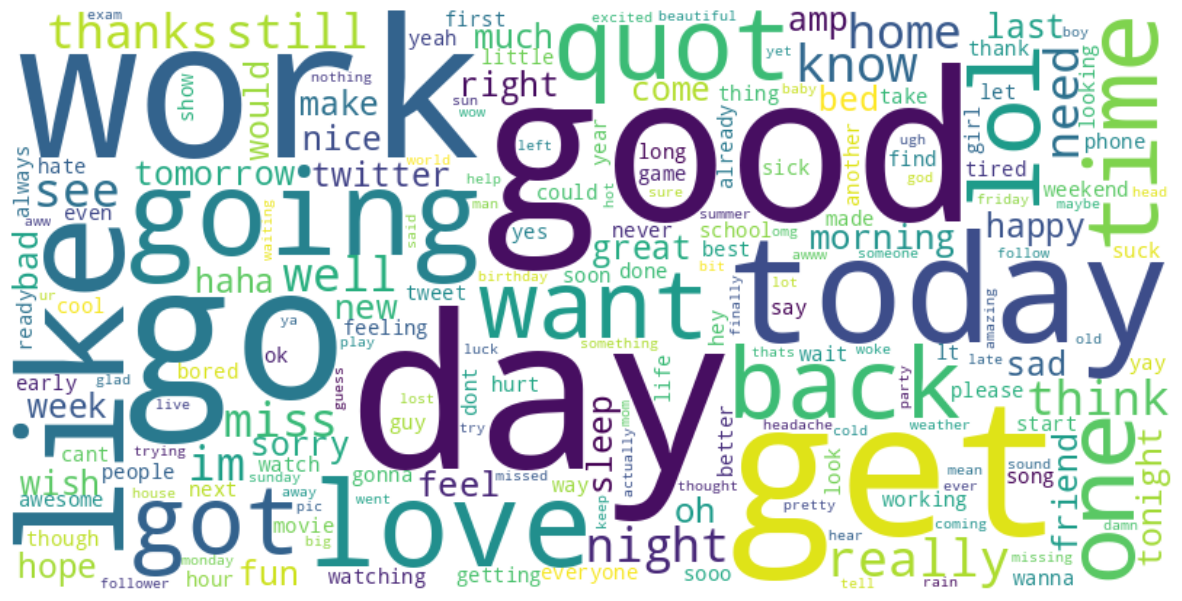

In [ ]:
#Wordcloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(tfidf_word_freq)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The above figure is the “WordCloud" for TF-IDF, it is not that different from the BoW word cloud and as a result, not very helpful for sentiment analysis. But it is still helpful to see what kind of words are most common.

### Word2Vec

In [ ]:
def get_word_embedding(word, model):
    if word in model.key_to_index:
        return model[word]
    else:
        return np.zeros(model.vector_size)

In [ ]:
#!!!!!! This model is trained on 10% of the data!!!!!!!!
nltk.download('punkt')

#tokenized_texts = [word_tokenize(text.lower()) for text in stemlem_texts]
word2vec_model = Word2Vec(sentences=stemlem_texts, vector_size=50, window=5, min_count=1)

word_embeddings = word2vec_model.wv

document_vectors = []
for tokens in stemlem_texts:
     document_vector = [get_word_embedding(word, word_embeddings) for word in tokens]
     document_vector_mean = np.mean(document_vector if len(document_vector) >0 else [np.zeros(word_embeddings.vector_size)], axis=0)
     document_vectors = document_vectors + [document_vector_mean]

embeddings = np.array(document_vectors)
doc_vec=pd.DataFrame(embeddings)
doc_vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.144330,0.241260,-0.019583,0.127436,0.072151,0.178172,-0.212966,-0.256542,-0.203123,0.197951,...,-0.340223,0.138902,0.347273,-0.013476,0.105004,0.152560,-0.204182,0.071115,0.041051,-0.064543
1,-0.293104,0.245754,0.129105,0.050411,0.164482,0.068427,-0.180630,-0.239666,-0.093200,0.180699,...,-0.298954,0.221614,0.273565,-0.006805,0.064453,0.159491,-0.092528,-0.071575,0.004345,-0.195243
2,-0.234723,0.259315,0.117087,0.079264,0.161019,0.040663,-0.172977,-0.268536,-0.141657,0.183180,...,-0.304803,0.075863,0.233445,0.020725,0.125701,0.196732,-0.109392,-0.129273,-0.042151,-0.210555
3,-0.219693,0.303951,0.019351,0.098396,0.087799,0.063918,-0.181901,-0.381137,-0.209900,0.201744,...,-0.367090,0.142378,0.209803,0.035935,0.170931,0.224800,-0.042821,-0.093142,-0.005853,-0.223470
4,-0.371074,0.265075,-0.043256,0.096745,0.165574,0.131927,-0.089140,-0.333077,-0.190583,0.160499,...,-0.297628,0.190834,0.240723,0.037290,0.174661,0.171788,-0.186584,-0.035838,0.144448,-0.174066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,-0.203642,0.062700,0.198850,-0.068459,-0.026076,-0.011907,-0.192210,-0.093623,0.046540,0.187909,...,-0.090224,0.162462,0.254818,-0.138055,0.126506,0.301208,0.033659,-0.023163,0.129759,-0.177839
159996,-0.203096,0.294014,0.053653,0.164591,0.045204,0.018807,-0.230853,-0.341847,-0.250252,0.192348,...,-0.426137,0.116579,0.374762,-0.027887,0.158168,0.214578,-0.211973,-0.010128,0.080586,-0.130847
159997,-0.142361,0.373988,0.048114,0.143392,0.038331,0.038464,-0.151974,-0.403050,-0.177360,0.295183,...,-0.354667,0.091522,0.264768,-0.030703,0.126289,0.232370,-0.074954,-0.074674,-0.028940,-0.212782
159998,-0.272488,0.307446,-0.005998,0.018995,0.009002,0.108436,-0.262821,-0.340476,-0.166250,0.253585,...,-0.228815,0.021647,0.114180,0.145594,0.199286,0.229645,-0.134857,-0.228235,-0.149188,-0.243041


We used Word2Vec to generate word embeddings, which represent words as vectors in a continuous vector space. This allows us to capture semantic relationships between words based on their contexts in the dataset. By doing so, we can understand the contextual meanings of words and their associations, especially in the context of tweets, which often contain informal language and abbreviations.

### n-grams

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(stemlem_texts)

We initialized a `CountVectorizer` object to convert into a matrix of token counts, considering both unigrams and bigrams.

### Word2vec using a pretrained model (Glove)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2024-03-03 18:59:51--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2024-03-03 18:59:51--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2024-03-03 18:59:51--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
glove_input_file = '/content/glove.twitter.27B.50d.txt'

glove_model = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)

In [ ]:
word_embeddings_pretrained = glove_model

document_vectors = []
for tokens in stemlem_texts:
     document_vector = [get_word_embedding(word, word_embeddings_pretrained) for word in tokens]
     document_vector_mean = np.mean(document_vector if len(document_vector) >0 else [np.zeros(word_embeddings_pretrained.vector_size)], axis=0)
     document_vectors = document_vectors + [document_vector_mean]

embeddings_pretrained = np.array(document_vectors)
doc_vec=pd.DataFrame(embeddings_pretrained)
doc_vec

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.327748,-0.057157,0.079543,-0.142807,-0.079977,0.028805,-0.472192,0.110891,-0.055123,0.272007,...,-2.405412,0.381025,0.194003,-0.053337,-0.071185,-0.051396,-0.028134,-0.465951,0.237399,-0.583602
1,0.218595,0.087058,0.087786,-0.062978,-0.170475,-0.001903,-0.525127,0.061760,0.046752,0.278424,...,-2.196350,0.253560,0.235922,-0.204986,-0.082714,-0.036388,0.064796,-0.355509,0.190848,-0.620873
2,0.162308,0.057247,0.133351,-0.084018,-0.094954,-0.016927,-0.487428,0.070824,0.019894,0.319571,...,-2.189602,0.206418,0.254999,-0.163612,-0.038836,-0.051533,0.099800,-0.357281,0.086139,-0.579750
3,0.273254,0.015283,0.092443,-0.116143,-0.132632,-0.021404,-0.507049,0.088132,0.016652,0.405610,...,-2.312944,0.302297,0.275098,-0.200739,-0.079404,-0.049369,0.031216,-0.467591,0.147771,-0.628645
4,0.134463,0.205955,0.289704,-0.142443,-0.103194,-0.002173,-0.493991,0.095752,0.012667,0.302574,...,-2.466465,0.358284,0.291871,-0.298478,-0.022134,0.018981,0.084168,-0.441862,0.013512,-0.726342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,0.252963,0.017250,0.061654,-0.109253,-0.248946,0.014032,-0.483620,0.177677,-0.055349,0.444195,...,-2.281021,0.283340,0.322321,-0.237567,0.030456,-0.126073,0.137050,-0.502071,0.229144,-0.459317
159996,0.228285,0.036048,0.121910,-0.062472,-0.137216,0.010740,-0.522042,0.035292,0.007976,0.247393,...,-2.402200,0.303214,0.253026,-0.147933,0.027159,-0.027170,0.057405,-0.373292,0.165883,-0.635286
159997,0.267621,0.088755,0.173903,-0.054145,-0.079780,0.006721,-0.583971,0.090313,0.031174,0.334454,...,-2.500685,0.306663,0.216583,-0.283957,-0.066781,-0.056843,0.047999,-0.480055,0.171240,-0.621823
159998,0.140681,0.263796,0.110352,-0.080439,-0.189648,-0.029538,-0.413599,0.082399,-0.028222,0.533171,...,-2.200043,0.280226,0.349733,-0.271460,-0.031464,-0.040736,0.045154,-0.384971,0.142499,-0.719365


In the above code, we created document-level embeddings from a collection of tokenized texts using a pretrained GloVe model. We stored the results into a dataframe, called `doc_vec`.

### Random Forest

**Using Word2Vec**

In [ ]:
#!!!!!! This model is trained on 10% of the data!!!!!!!!
X_train, X_test, y_train, y_test = train_test_split(embeddings, df_new['polarity'], test_size=0.2, random_state=42)

# train the model
model_word2vec_classification = RandomForestClassifier()
model_word2vec_classification.fit(X_train, y_train)

# Predict on the test data
y_pred2 = model_word2vec_classification.predict(X_test)

# Evaluate the model
f1_score = sklearn.metrics.f1_score(y_test, y_pred2)
print(f"f1_score: {f1_score}")
print(sklearn.metrics.classification_report(y_test,y_pred2))
pd.DataFrame(confusion_matrix(y_test, y_pred2, normalize='true'), columns=model_word2vec_classification.classes_, index=model_word2vec_classification.classes_ )

f1_score: 0.5784800126402275
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     15878
           1       0.59      0.57      0.58     16122

    accuracy                           0.58     32000
   macro avg       0.58      0.58      0.58     32000
weighted avg       0.58      0.58      0.58     32000



,0,1
0,0.598816,0.401184
1,0.432266,0.567734


In the above code, we performed random forest classifier on the results from Word2Vec model. This resulted in F1 score of 58%.

**Using pre trained model**

In [ ]:
#!!!!!! This model is trained on 10% of the data!!!!!!!!
X_train, X_test, y_train, y_test = train_test_split(embeddings_pretrained, df_new['polarity'], test_size=0.2, random_state=42)

# train the model
model_word2vec_classification = RandomForestClassifier()
model_word2vec_classification.fit(X_train, y_train)

# Predict on the test data
y_pred2 = model_word2vec_classification.predict(X_test)

# Evaluate the model
f1_score = sklearn.metrics.f1_score(y_test, y_pred2)
print(f"f1_score: {f1_score}")
print(sklearn.metrics.classification_report(y_test,y_pred2))
pd.DataFrame(confusion_matrix(y_test, y_pred2, normalize='true'), columns=model_word2vec_classification.classes_, index=model_word2vec_classification.classes_ )

f1_score: 0.5719685039370078
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     15878
           1       0.58      0.56      0.57     16122

    accuracy                           0.58     32000
   macro avg       0.58      0.58      0.58     32000
weighted avg       0.58      0.58      0.58     32000



,0,1
0,0.587605,0.412395
1,0.436794,0.563206


In the above code, we performed random forest classifier on the results from pre trained model, GloVe. This resulted in F1 score of 57%.

**Using n-grams**

In [ ]:
#This model is run with 1.75% of the dataset
y = df_new['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
print(classification_report(y_test, y_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true'), columns=model.classes_, index=model.classes_))

F1 Score: 0.738493363213239
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      2848
           1       0.70      0.78      0.74      2752

    accuracy                           0.73      5600
   macro avg       0.73      0.73      0.73      5600
weighted avg       0.73      0.73      0.73      5600

          0         1
0  0.681531  0.318469
1  0.221657  0.778343


In the above code, we performed random forest classifier on the results from n-grams sequence of unigrams and bigrams. This resulted in F1 score of 74%.

### Sentiment analysis: analyzing similiarities

In [ ]:
ideal_pos = "awesome, amazing, love, great, fantastic, like, good, excellent, wonderful, superb, happy, excited, best, nice, beautiful, cool, fun, joy, smile, thank, enjoy"

ideal_neg = "bad, terrible, hate, awful, horrible, disappointing, sad, angry, dislike, worst, ugh, annoying, frustrating, miserable, sucks, depressing, upset, painful, regret, hard, miss, sorry, hurt, lost, alone, fuck, shit, whore, slut, bitch, cunt"

Here, we stored a set of positive and negative words in `ideal_pos` and `ideal_neg` variables.

#### Finding Similarities

**Using Pre-trained model**

In [ ]:
ideal_pos_embeddings = np.mean([get_word_embedding(word, word_embeddings_pretrained) for word in ideal_pos if word in word_embeddings_pretrained], axis=0).reshape(1, -1)
ideal_neg_embeddings = np.mean([get_word_embedding(word, word_embeddings_pretrained) for word in ideal_neg if word in word_embeddings_pretrained], axis=0).reshape(1, -1)

In [ ]:
# using 10% of the data
# Function to calculate the embedding vector for a single tweet
def tweet_embedding(tweet, word_embeddings):
    tokens = word_tokenize(tweet)
    token_embeddings = [get_word_embedding(word, word_embeddings) for word in tokens if word in word_embeddings]
    if len(token_embeddings) > 0:
        return np.mean(token_embeddings, axis=0)
    else:
        return np.zeros(word_embeddings.vector_size)

# Calculate embeddings for each tweet and store them in a list
tweet_embeddings = df_new['text'].apply(lambda tweet: tweet_embedding(tweet, word_embeddings_pretrained))

# Calculate cosine similarities with ideal positive and negative embeddings
df_new['similarity_pos'] = tweet_embeddings.apply(lambda emb: cosine_similarity(emb.reshape(1, -1), ideal_pos_embeddings)[0][0] if len(emb) > 0 else 0)
df_new['similarity_neg'] = tweet_embeddings.apply(lambda emb: cosine_similarity(emb.reshape(1, -1), ideal_neg_embeddings)[0][0] if len(emb) > 0 else 0)

In the above code, we performed cosine similarity on ideal positive and negative embeddings and 10% of the data sample.

In [ ]:
df_new['sentiment'] = np.where(df_new['similarity_pos'] - df_new['similarity_neg'] > 0, 1, 0)
df_new['sentiment'].value_counts()

0    158726
1      1274
Name: sentiment, dtype: int64

Then, we created a column, named `sentiment`, which is calculated by comparing the cosine similarity. If the result of this calculation is 1, the sentiment of the text is deemed to be positive and if it is 0, then it is inferred to be negative.

Then, we executed value_counts() on the sentiment column, which showed the results to be 158,726 negative texts and 1,274 positive texts.

In [ ]:
confusion_matrix(df_new['polarity'], df_new['sentiment'], normalize='true')

array([[0.9934471 , 0.0065529 ],
       [0.99063451, 0.00936549]])

In [ ]:
accuracy = accuracy_score(df_new['polarity'], df_new['sentiment'])
precision = precision_score(df_new['polarity'], df_new['sentiment'], average='macro')
recall = recall_score(df_new['polarity'], df_new['sentiment'], average='macro')
f1 = f1_score(df_new['polarity'], df_new['sentiment'], average='macro')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.50025
Precision: 0.5445078672050219
Recall: 0.5014062958912691
F1 Score: 0.34161469936530925


Then, we calculated various metrics of this model on the data. Then, we found the accuracy to be 50%, precision to be 54%, recall to be 50% and F1 score to be 34%.

**Using Word2vec**

We performed similar process on the results from Word2Vec.

In [ ]:
ideal_pos_embeddings = np.mean([get_word_embedding(word, word_embeddings) for word in ideal_pos if word in word_embeddings], axis=0).reshape(1, -1)
ideal_neg_embeddings = np.mean([get_word_embedding(word, word_embeddings) for word in ideal_neg if word in word_embeddings], axis=0).reshape(1, -1)

In [ ]:
# using 10% of the data

# Function to calculate the embedding vector for a single tweet
def tweet_embedding(tweet, word_embeddings):
    tokens = word_tokenize(tweet)
    token_embeddings = [get_word_embedding(word, word_embeddings) for word in tokens if word in word_embeddings]
    if len(token_embeddings) > 0:
        return np.mean(token_embeddings, axis=0)
    else:
        return np.zeros(word_embeddings.vector_size)

# Calculate embeddings for each tweet and store them in a list
tweet_embeddings = df_new['text'].apply(lambda tweet: tweet_embedding(tweet, word_embeddings))

# Calculate cosine similarities with ideal positive and negative embeddings
df_new['similarity_pos'] = tweet_embeddings.apply(lambda emb: cosine_similarity(emb.reshape(1, -1), ideal_pos_embeddings)[0][0] if len(emb) > 0 else 0)
df_new['similarity_neg'] = tweet_embeddings.apply(lambda emb: cosine_similarity(emb.reshape(1, -1), ideal_neg_embeddings)[0][0] if len(emb) > 0 else 0)



In [ ]:
df_new['sentiment'] = np.where(df_new['similarity_pos'] - df_new['similarity_neg'] > 0, 1, 0)
df_new['sentiment'].value_counts()

0    81647
1    78353
Name: sentiment, dtype: int64

Here, we found 81,647 negative texts and 78,353 positive texts.

In [ ]:
confusion_matrix(df_new['polarity'], df_new['sentiment'], normalize='true')

array([[0.46280008, 0.53719992],
       [0.55756472, 0.44243528]])

In [ ]:
accuracy = accuracy_score(df_new['polarity'], df_new['sentiment'])
precision = precision_score(df_new['polarity'], df_new['sentiment'], average='macro')
recall = recall_score(df_new['polarity'], df_new['sentiment'], average='macro')
f1 = f1_score(df_new['polarity'], df_new['sentiment'], average='macro')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.45259375
Precision: 0.4525978491404623
Recall: 0.45261767864363034
F1 Score: 0.45254822850842225


Here, we found the accuracy, precision, recall and F1 score to be approximately 45%.

## Appendix

**Text Cleaning 1**

In [ ]:
# convert every character to lower case.
df_new['text'] = df_new['text'].str.lower()

NameError: name 'df_new' is not defined

In [ ]:
http_texts = df_new[df_new['text'].str.startswith('http')]

print(http_texts)

         polarity          id                          date     query  \
1108196         1  1971694036  Sat May 30 07:41:17 PDT 2009  NO_QUERY   
870302          1  1678338430  Sat May 02 06:22:48 PDT 2009  NO_QUERY   
783542          0  2323944710  Thu Jun 25 01:53:23 PDT 2009  NO_QUERY   
537274          0  2198707463  Tue Jun 16 16:27:25 PDT 2009  NO_QUERY   
629217          0  2231568837  Thu Jun 18 18:43:49 PDT 2009  NO_QUERY   
...           ...         ...                           ...       ...   
1599857         1  2193552692  Tue Jun 16 08:36:48 PDT 2009  NO_QUERY   
359656          0  2045919223  Fri Jun 05 11:25:52 PDT 2009  NO_QUERY   
1267160         1  1999801315  Mon Jun 01 20:50:52 PDT 2009  NO_QUERY   
840511          1  1559772281  Sun Apr 19 12:00:38 PDT 2009  NO_QUERY   
397671          0  2056690961  Sat Jun 06 11:36:47 PDT 2009  NO_QUERY   

                   user                                               text  
1108196           suffe  http://mobypicture.co

In [ ]:
# remove URL links but keeps the rows
df_new['text'] = df_new['text'].str.replace(r'http\S+', '', regex=True)


In [ ]:
# check for URL removal
df_new.loc[870302]

polarity                                                    1
id                                                 1678338430
date                             Sat May 02 06:22:48 PDT 2009
query                                                NO_QUERY
user                                           kayotickitchen
text         - before his hair cut. i just wanna kiss that...
Name: 870302, dtype: object

In [ ]:
def clean_text(text):
    # Regular expression to match emojis and old school emoji
    emoji_pattern = re.compile("["      # This pattern has been generated with the help of AI
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+|[:;=]-?[)DpPoO(/\\|*]"  # Additional pattern for old school emoji of this kind ":), ;)"
        , flags=re.UNICODE)

    # This function check if a string contains an emoji
    def contains_emoji(s):
        return emoji_pattern.search(s) is not None

    # Define a pattern to match the unwanted characters, while keeping traditional emoticons and emojis
    unwanted_chars_pattern = r'[^a-zA-Z0-9\s]+'

    # Split the text into words and symbols and Rebuild the text keeping emojis and alpha numerical characters
    split_text = re.findall(r'\w+|[^\w\s]|[\s]', text, re.UNICODE)


    cleaned_text = ''.join([word if contains_emoji(word) or re.match(unwanted_chars_pattern, word) is None or word.isspace() else ' ' for word in split_text])

    return cleaned_text.strip()

In [ ]:
# Cleaning from unwanted characters
df_new['text'] = df_new['text'].apply(clean_text)

Check if there are tweets with URLs.

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28000 entries, 541200 to 1558639
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  28000 non-null  int64 
 1   id        28000 non-null  int64 
 2   date      28000 non-null  object
 3   query     28000 non-null  object
 4   user      28000 non-null  object
 5   text      28000 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.5+ MB


**Using TF-IDF**

In [ ]:
#PCA for reducing dimensions
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

transformed_tdidf = pca.fit_transform(tfidf_array)
transformed_tdidf

total_explained_variance_100 = pca.explained_variance_ratio_.sum()
print(total_explained_variance_100)

0.15345153795060246


In [ ]:
#Crash too many dimension for TF-IDF
X_train, X_test, y_train, y_test = train_test_split(tfidf_array, df_new['polarity'], test_size=0.2, random_state=42)

# train the model
model_word2vec_classification = RandomForestClassifier()
model_word2vec_classification.fit(X_train, y_train)

# Predict on the test data
y_pred2 = model_word2vec_classification.predict(X_test)

# Evaluate the model
f1_score = sklearn.metrics.f1_score(y_test, y_pred2)
print(f"f1_score: {f1_score}")
print(sklearn.metrics.classification_report(y_test,y_pred2))
pd.DataFrame(confusion_matrix(y_test, y_pred2, normalize='true'), columns=model_word2vec_classification.classes_, index=model_word2vec_classification.classes_ )